## Simulating photonic lantern observables

This tutorial will be on how to simulate photonic lantern outputs.

The lantern observable simulation consists of two parts: 1) focal-plane field decomposition into spatial modes and 2) projecting them on the lantern's measurement basis, defined by transfer matrix.

The first step is done using ``sim.PLOverlapCalculator``. The second step is done by ``sim.Device`` as a transfer matrix as an input.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PLsim import simulator as sim
from PLsim import lantern as l
from PLsim import scene as s

The ``PLOverlapCalculator`` class calculates the spatial modes of the multimode input of the lantern and decomposes focal-plane light in this mode basis. One needs to input the properties of the beam (unobstructed circular aperture is assumed) and the lantern's multimode geometry and refractive indices (LP modes are assumed, with the geometry of circular step-index fiber). 

For the default refractive index settings, about 6 um core radius gives 3-moded lantern, 10 um gives 6-moded lantern, and 16.5 um gives 19-moded lantern.

In [ ]:
# let's simulate 3-port lantern with focal ratio of 5.3
oc = sim.PLOverlapCalculator(dim = 385, # defines the resolution of the grid. use odd numbers.
                             telescope_diameter = 10, # in meters
                             wavelength = 1.55e-6, # in meters
                             nclad = 1.444, # lantern core refractive index
                             njack = 1.444 - 5.5e-3, # lantern cladding refractive index
                             rclad = 6e-6, # lantern core radius in meters,
                             focal_length = 53, # focal length in meters. if not provided,
                             # it searches for the focal length that gives the best coupling efficiency.
                             )

Available modes:  [(0, 1, 'cos'), (1, 1, 'cos'), (1, 1, 'sin')]
Calculated k0, V, modes
LP modes stored in self.u0s
Coupling efficiency: 0.8167813749438008
Pupil functions calculated and stored in self.u0s_pupil
Cross-correlated pupil plane LP modes stored in self.full_ccpupils


Now define the lantern's transfer matrix and the ``Device`` class. Let's assume a mode-selective lantern, which has an identity matrix.

In [6]:
U = np.identity(3)
device_PL = sim.Device(lantern_matrix = U, verbose=False)

### Example 1: simulate point source response

Simulation of point source response is done by computing overlaps using ``oc.compute_overlap``.

In [45]:
# positions in radians
xpos = 0 
ypos = 5e-3 / 206265 # let's consider slight misalignment in one axis by 5 mas

overlap = oc.compute_overlap(xpos, ypos)

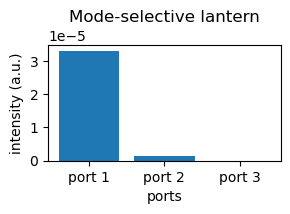

In [46]:
intens = device_PL.calculate_output_intensities(overlap)[0][0]
plt.figure(figsize=(3,1.5))
plt.bar(range(len(intens)), intens)
plt.xlabel('ports')
plt.xticks(range(len(intens)), ['port 1', 'port 2', 'port 3'])
plt.ylabel('intensity (a.u.)')
plt.title('Mode-selective lantern')
plt.show()

### Example 2: simulate coupling maps

Use ``oc.compute_overlap_grid_2d`` to compute overlaps in a 2D grid

In [47]:
fov = 100e-3 / 206265 # field of view in radians
ngrid = 15 # number of grid points along one axis

overlap_grid = oc.compute_overlap_grid_2d(fov, ngrid, xoffset=0, yoffset=0)

In [48]:
intens_grid = device_PL.calculate_output_intensities(overlap_grid)[0]

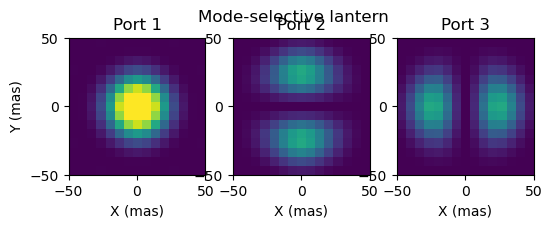

In [56]:
fig, axs = plt.subplots(ncols=3, figsize=(6,2))
for i in range(3):
    axs[i].imshow((intens_grid[:,i]).reshape((ngrid, ngrid)), vmin=0, vmax=2.5e-5,
                  extent = [-fov/2*206265e3, fov/2*206265e3, -fov/2*206265e3, fov/2*206265e3])
    axs[i].set_title(f'Port {i+1}')
    axs[i].set_xlabel('X (mas)')
axs[0].set_ylabel('Y (mas)')
plt.suptitle('Mode-selective lantern')
plt.show()

### Example 3: simulate an extended star

Use ``oc.compute_overlap_disk`` to compute overlaps for extended star

In [50]:
# simulate an extended star, with radius of 10 mas and ellipticity of 1 (circular)
overlap_star = oc.compute_overlap_disk(radius = 10e-3/206265, ellip=1)


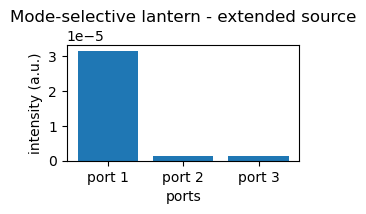

In [59]:
intens_star = device_PL.calculate_output_intensities(overlap_star)[0][0]
plt.figure(figsize=(3,1.5))
plt.bar(range(len(intens_star)), intens_star)
plt.xlabel('ports')
plt.xticks(range(len(intens_star)), ['port 1', 'port 2', 'port 3'])
plt.ylabel('intensity (a.u.)')
plt.title('Mode-selective lantern - extended source')
plt.show()

## Use a different transfer matrix

The nice thing about this structure is that once overlap is computed, one can use whatever transfer matrix to simulate the observables for different lantern transfer matrix.

Let's consider a random unitary matrix, representing a standard lantern.

In [64]:
from scipy.stats import unitary_group
np.random.seed(123456)
U_random = unitary_group.rvs(3)
device_PL_standard = sim.Device(lantern_matrix = U_random, verbose=False)

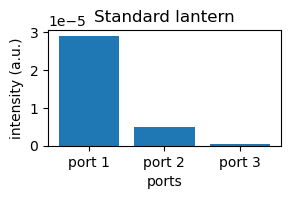

In [65]:
intens_standard = device_PL_standard.calculate_output_intensities(overlap)[0][0]
plt.figure(figsize=(3,1.5))
plt.bar(range(len(intens_standard)), intens_standard)
plt.xlabel('ports')
plt.xticks(range(len(intens_standard)), ['port 1', 'port 2', 'port 3'])
plt.ylabel('intensity (a.u.)')
plt.title('Standard lantern')
plt.show()

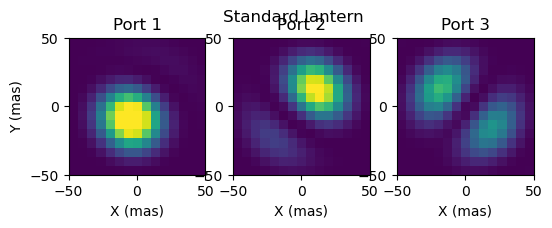

In [66]:
intens_standard_grid = device_PL_standard.calculate_output_intensities(overlap_grid)[0]

fig, axs = plt.subplots(ncols=3, figsize=(6,2))
for i in range(3):
    axs[i].imshow((intens_standard_grid[:,i]).reshape((ngrid, ngrid)), vmin=0, vmax=2.5e-5,
                  extent = [-fov/2*206265e3, fov/2*206265e3, -fov/2*206265e3, fov/2*206265e3])
    axs[i].set_title(f'Port {i+1}')
    axs[i].set_xlabel('X (mas)')
axs[0].set_ylabel('Y (mas)')
plt.suptitle('Standard lantern')
plt.show()

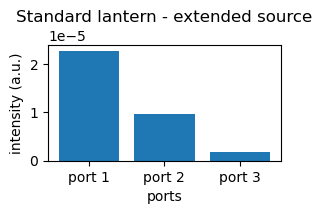

In [67]:
intens_standard_star = device_PL_standard.calculate_output_intensities(overlap_star)[0][0]
plt.figure(figsize=(3,1.5))
plt.bar(range(len(intens_standard_star)), intens_standard_star)
plt.xlabel('ports')
plt.xticks(range(len(intens_standard_star)), ['port 1', 'port 2', 'port 3'])
plt.ylabel('intensity (a.u.)')
plt.title('Standard lantern - extended source')
plt.show()